# TestCase5 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 5
version = 1
param_num = 1

In [2]:
assert testcase == 5 and version == 1 and param_num == 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.utils import create_tree

from modules.geometry import Donut
from modules.fenics_expressions_5 import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [5]:
from modules.testcases.d2.test_5.test_5_v1 import Run_laplacian2D,Poisson_2D
from modules.solver_fem_5 import FEMSolver
from modules.problem import TestCase5
problem = TestCase5(v=version)

result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cuda


bigcenter :  [0.0, 0.0]
bigradius :  1.0
smallcenter :  [0.0, 0.0]
smallradius :  0.25
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe5.pth
network loaded
Error  tensor([0.0010])


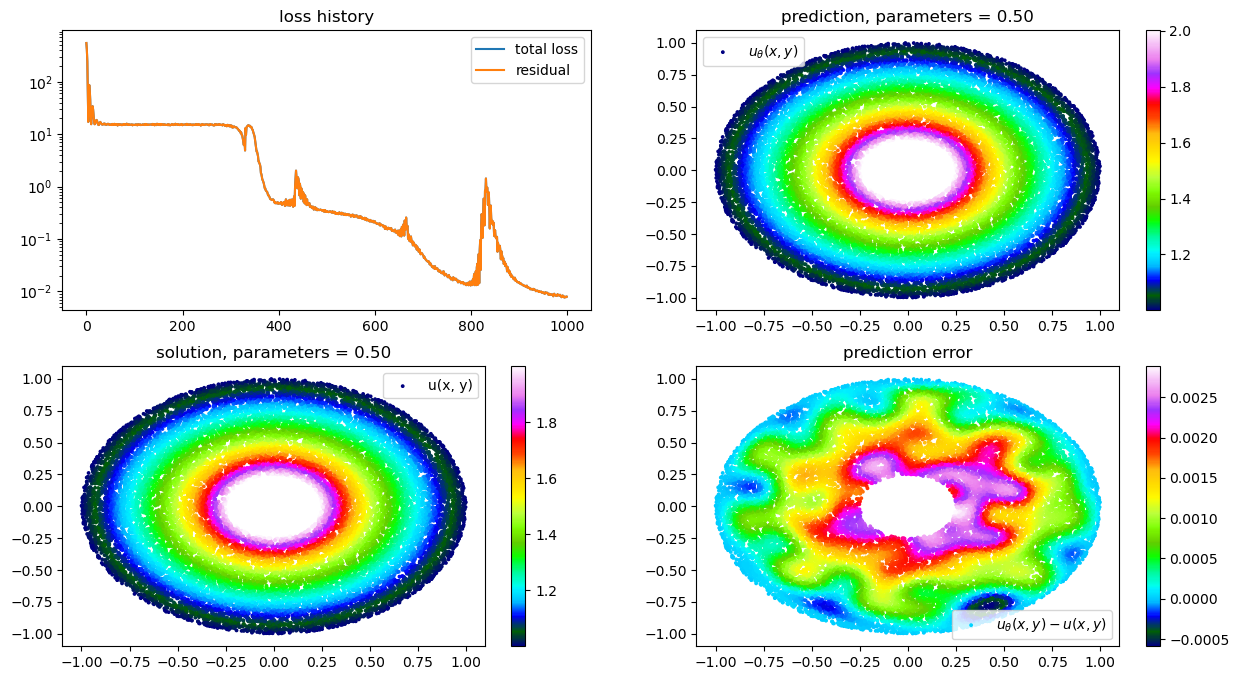

In [6]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [7]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.5]


## Convergence FEM

In [26]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)  
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [27]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree,new_run=True)

Run FEM
hmax =  0.16660094771444728
      Calling FFC just-in-time (JIT) compiler, this may take some time.
nb_vert=16, norme_L2=0.006358630262057649
hmax =  0.08694977804807888
nb_vert=32, norme_L2=0.0015362998285251474
hmax =  0.04347576862597117
nb_vert=64, norme_L2=0.00038595400777288426
hmax =  0.021977593606715005
nb_vert=128, norme_L2=9.906250226881571e-05
hmax =  0.010988658015609403
nb_vert=256, norme_L2=2.4111139424274202e-05


degree=1
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree3.csv


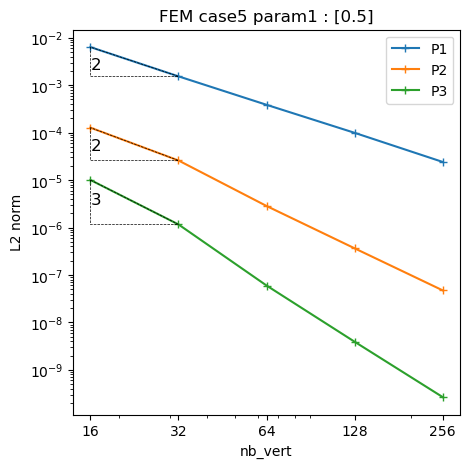

In [33]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_FEM[1],tab_err_FEM[1]]
    end = [tab_nb_vert_FEM[0],tab_err_FEM[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [34]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree3.csv


## Convergence PINNs+Corr

In [35]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

In [40]:
degree_PINNs = 6

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False,plot_all = False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            
            tab_h_Corr.append(solver.h)
            
            # Compute PINNs solution
            V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
            u_PINNs = FEniCSpred(0,V_test,trainer)
            u_PINNs_inter = FEniCSpred(0,solver.V,trainer)
            
            # Compute PINNs Error
            u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
            
            uref_Vex = df.interpolate(u_ref,solver.V_ex)
            sol_Vex = df.interpolate(u_PINNs,solver.V_ex)
            norme_L2_PINNs = (df.assemble((((uref_Vex - sol_Vex)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

            print(f"# norme_L2_PINNs={norme_L2_PINNs}")

            sol,C_tild,norme_L2 = solver.corr_add(0,u_PINNs,u_PINNs_inter)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
            #### PLOTT
            if plot_all and nb_vert in [16,32,64]:
                colormap = "jet"

                C_ex = df.Function(solver.V)
                u_ref_inter = df.interpolate(u_ref,solver.V)
                C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_inter.vector()[:]

                plt.figure(figsize=(15,10))

                plt.subplot(2,3,1)
                c = df.plot(C_ex,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex")

                plt.subplot(2,3,2)
                c = df.plot(C_tild,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_tild")

                plt.subplot(2,3,3)
                error = df.Function(solver.V)
                error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex-C_tild")
                
                plt.subplot(2,3,4)
                c = df.plot(u_ref_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("u_ex")
                
                plt.subplot(2,3,5)
                # sol_inter = df.project(sol,solver.V)
                sol_inter = df.Function(solver.V)
                sol_inter.vector()[:] = u_PINNs_inter.vector()[:] + C_tild.vector()[:]
                c = df.plot(sol_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("sol")
                
                plt.subplot(2,3,6)
                error = df.Function(solver.V)
                error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title(f"u_ex-sol\nL2 norm : {norme_L2:.2e}")    
                
                plt.suptitle(f"nb_vert={nb_vert}")
                
                plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}.png')

        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [41]:
degree = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(degree)

hmax =  0.16660094771444728
# norme_L2_PINNs=0.0009535031687654833
nb_vert=16, norme_L2=5.6194905427608164e-05
hmax =  0.08694977804807888
# norme_L2_PINNs=0.000950702441753837
nb_vert=32, norme_L2=1.8260443538332413e-05
hmax =  0.04347576862597117
# norme_L2_PINNs=0.0009498706625085393
nb_vert=64, norme_L2=4.956577884647879e-06


degree=1
Read csv file ../../../results/2D/testcase5/version1/cvg/Corr_case5_param1_degree1.csv


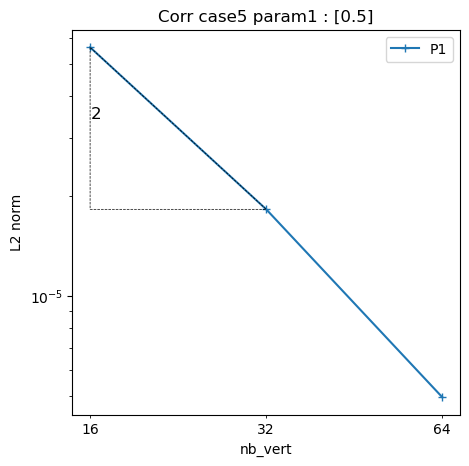

In [42]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_Corr[1],tab_err_Corr[1]]
    end = [tab_nb_vert_Corr[0],tab_err_Corr[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [43]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/2D/testcase5/version1/cvg/Corr_case5_param1_degree1.csv


## Plots

degree=1
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase5/version1/cvg/FEM_case5_param1_degree3.csv
degree=1
Read csv file ../../../results/2D/testcase5/version1/cvg/Corr_case5_param1_degree1.csv


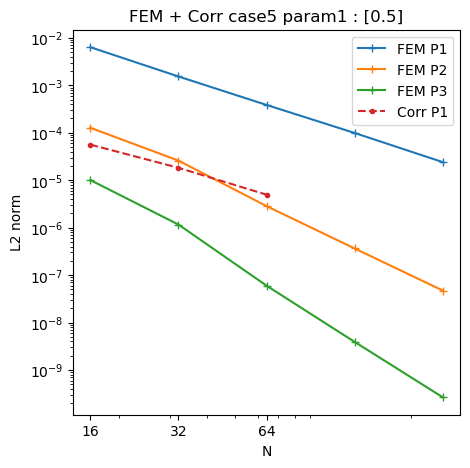

In [44]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')